### Pneumonia

        

In [1]:
# Importing Libraries and Dependencies
import numpy as np 
import pandas as pd
import os
import random
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_confusion_matrix


import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

/home/oem/Desarrollo/Master/Homework/arf/covid19_x-ray_images/venv/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


### Seed

Seed in machine learning is a pseudorandom number generator. By setting value of seed we will be able to generate same pattern of numbers.

In [2]:
seed = 240
np.random.seed(seed)
tf.random.set_seed(seed)

### Glimpse on the dataset

The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal). Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patient's routine clinical care. For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans.

- **ravel()** - Library level function that returns an original array
- **tight_layout()** - Adjusts subplot params and fits the plot in area

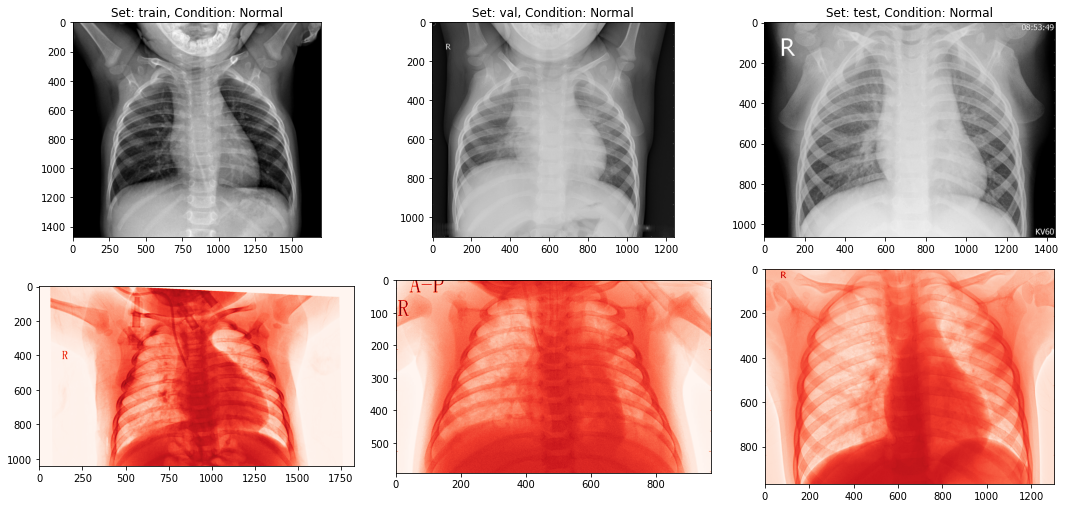

In [3]:
# Importing Dataset

inputs = '../DataSet1/chest-xray-pneumonia/chest_xray/'

fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = inputs +_set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]), cmap='Reds')
plt.savefig('Dataset_images.png')

### Splitting dataset

- Pneumonia Images: Train - 3875 , Validation - 8, Test - 390
- Normal Images: Train - 1341, Validation - 8, Test - 234

In [4]:
for _set in ['train', 'val', 'test']:
    n_normal = len(os.listdir(inputs + _set + '/NORMAL'))
    n_infect = len(os.listdir(inputs + _set + '/PNEUMONIA'))
    print('Set: {}, normal images: {}, pneumonia images: {}'.format(_set, n_normal, n_infect))

Set: train, normal images: 1342, pneumonia images: 3876
Set: val, normal images: 9, pneumonia images: 9
Set: test, normal images: 234, pneumonia images: 390


### Data Augmentation

Data Augmentation is an effective way of increasing the training set size. It allows model to see more diversed datapoints that are representative during training.

Why rescale to 1./255 ?

Every image image is made by pixel having value in range 0-255. Where 0 is black and 255 is white. Since maximum pixel value is 255, we transform every pixel value from range [0,255] -> [0,1]

Know more about Rescaling from this LinkedIN article: [Keras Image Processing](https://www.linkedin.com/pulse/keras-image-preprocessing-scaling-pixels-training-adwin-jahn/)

In [5]:
def data_processing(img_dims, batch_size):
    
    #Data Augmentation Images
    train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
    test_val_datagen = ImageDataGenerator(rescale=1./255)
    
    train_gen = train_datagen.flow_from_directory(directory=inputs + 'train', target_size=(img_dims, img_dims), batch_size=batch_size, class_mode='binary', shuffle=True)
    test_gen = test_val_datagen.flow_from_directory(directory=inputs + 'test', target_size=(img_dims, img_dims), batch_size=batch_size, class_mode='binary', shuffle=True)
    
    test_data = []
    test_labels = []
    
    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(inputs + 'test' + cond)):
            img = plt.imread(inputs + 'test'+cond+img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/NORMAL/':
                label = 0
            elif cond=='/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return (train_gen, test_gen, test_data, test_labels)

### Parameters

img_dims = 150

epochs - Number of times the training vectors are used to update weights

batch_size - Number of samples propagated through network, from total trainig samples the algorithm takes first 128 training dataset from (1 to 128) and trains the network. And subsequently trains with set of 128 till end.

In [6]:
img_dims = 150
epochs = 10
batch_size = 32

train_gen, test_gen, test_data, test_labels = data_processing(img_dims, batch_size)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### Constructing CNN

In [7]:
input_shape = Input(shape=(img_dims, img_dims, 3))

# First convulution block
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(input_shape)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)


# Second convolution block
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)


# Third convolution block
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Fourth convolution block
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Fifth convolution block
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

### Additional Layers

In [8]:
# Flattening Layer , Dropout - Deactivate some neurons while training to reduce overfitting
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# Output layer
output = Dense(units=1, activation='sigmoid')(x)

### Optimizers and Loss

In [9]:
# Creating model
model = Model(inputs=input_shape, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

In [10]:
hist = model.fit(
           train_gen, steps_per_epoch=train_gen.samples // batch_size, 
           epochs=epochs, validation_data=test_gen, 
           validation_steps=test_gen.samples // batch_size, callbacks=[checkpoint, lr_reduce])

Epoch 1/10
163/163 [==============================] - 103s 625ms/step - loss: 0.4706 - accuracy: 0.7766 - val_loss: 0.7838 - val_accuracy: 0.6217
Epoch 2/10
163/163 [==============================] - 96s 588ms/step - loss: 0.3091 - accuracy: 0.8664 - val_loss: 0.7678 - val_accuracy: 0.6266
Epoch 3/10
163/163 [==============================] - 96s 588ms/step - loss: 0.2924 - accuracy: 0.8819 - val_loss: 1.2354 - val_accuracy: 0.6201
Epoch 4/10
163/163 [==============================] - 96s 588ms/step - loss: 0.2356 - accuracy: 0.9076 - val_loss: 0.5382 - val_accuracy: 0.6217
Epoch 5/10
163/163 [==============================] - 96s 588ms/step - loss: 0.2133 - accuracy: 0.9169 - val_loss: 2.1373 - val_accuracy: 0.6201
Epoch 6/10
163/163 [==============================] - 96s 589ms/step - loss: 0.2051 - accuracy: 0.9242 - val_loss: 0.3457 - val_accuracy: 0.8454
Epoch 7/10
163/163 [==============================] - 96s 588ms/step - loss: 0.1768 - accuracy: 0.9321 - val_loss: 0.9929 - val_a

## Save model

In [11]:
model.save("Pneumonia.h5")

### Visualizing Output

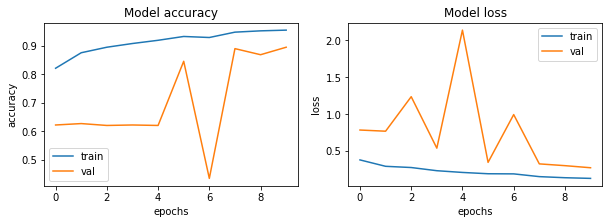

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
plt.savefig('Accuracy_VS_Loss.png')

CONFUSION MATRIX


<Figure size 432x288 with 0 Axes>

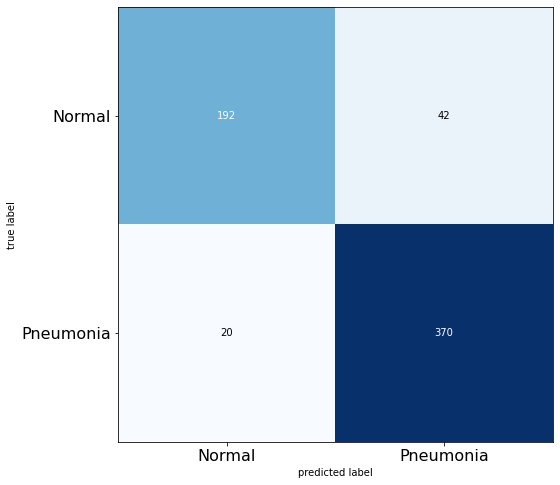


TESTING METRICS
Accuracy: 90.06410256410257%
Precision: 89.80582524271846%
F1-score: 92.26932668329177
Recall: 94.87179487179486%

TRAINING METRICS
Train accuracy: 95.48


In [15]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model.predict(test_data)

model_acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX')
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.savefig("Confusion_matrix.png")
plt.show()

print('\nTESTING METRICS')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(model_acc))
print('Precision: {}%'.format(precision))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))
print('Recall: {}%'.format(recall))


print('\nTRAINING METRICS')
print('Train accuracy: {}'.format(np.round((hist.history['accuracy'][-1])*100, 2)))